Используйте базу трафика с сайта компании.

Напишите модель для прогнозирования трафика.

При параметре `length = 60`, добейтесь максимально точного соответствия между графиками корреляции исходного сигнала и прогноза.

Загрузка всех библиотек

In [ ]:
# Работа с массивами
# Загрузка датасетов из облака google
import gdown
# Отрисовка графиков
import matplotlib.pyplot as plt
import numpy as np
# Работа с таблицами
import pandas as pd
from pylab import rcParams
# Нормировщики
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Основные слои
from tensorflow.keras.layers import (LSTM, BatchNormalization, Conv1D, Conv2D,
                                     Dense, Dropout, Flatten,
                                     GlobalMaxPooling1D, Input, MaxPooling1D,
                                     RepeatVector, concatenate)
# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Model, Sequential
# Оптимизаторы
from tensorflow.keras.optimizers import Adam
# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Отрисовка графики в ячейке colab
%matplotlib inline


Опишем параметры вывода графиков:

Настройка параметров графиков

Устанавливаются стандартные параметры для всех графиков:
- Стиль 'ggplot' для профессионального вида графиков
- Размер фигур по умолчанию 14x7 дюймов

In [2]:
# Назначение размера и стиля графиков по умолчанию
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

Загрузка датасета

Скачивание файла с данными трафика с сайта компании из облачного хранилища
с использованием библиотеки gdown.
Файл сохраняется в текущей директории под именем 'traff.csv'

In [3]:
#Загружаем базу трафика с сайта компании
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/traff.csv', None, quiet=True)

'traff.csv'

Загрузка и первичный просмотр данных

1. Загрузка CSV-файла с трафиком (без заголовков)
2. Назначение имен столбцам: 'Datetime' и 'Close'
3. Вывод первых строк данных для проверки

In [ ]:
# Загрузка данных
data = pd.read_csv('traff.csv', header=None, names=['Datetime', 'Close'])
data

,Datetime,Close
0,1/1/2017,"22,226.00"
1,1/2/2017,"29,593.00"
2,1/3/2017,"31,726.00"
3,1/4/2017,"32,684.00"
4,1/5/2017,"31,820.00"
...,...,...
1090,12/27/2019,"29,801.00"
1091,12/28/2019,"34,913.00"
1092,12/29/2019,"37,665.00"
1093,12/30/2019,"32,643.00"


Предобработка данных

1. Преобразование столбца с датой в индекс DataFrame
2. Удаление столбца с датой (так как он теперь в индексе)
3. Очистка и преобразование значений трафика:
   - Удаление кавычек
   - Замена запятых на точки
   - Преобразование в float и деление на 100
4. Добавление индикаторов:
   - Относительные изменения за 1-6 предыдущих периодов
5. Удаление строк с пропущенными значениями

In [20]:
# Преобразование столбца даты в индекс таблицы и удаление столбца даты
data.index = pd.to_datetime(data['Datetime'])
data.drop(columns='Datetime', inplace=True)

# Настройка имен столбцов
COL_DATE = 'Datetime'
COL_CLOSE = 'Close'
# Исправление столбца с ценой
data['Close'] = data['Close'].str.replace('"', '').str.replace(',', '').astype(float) / 100

# Задание гиперпараметров
INDICATOR_DEPTH = 6                       # Глубина расчета индикаторов тренда (шаги)
PREDICT_LAG = 1                           # Количество шагов в будущее для предсказания

# Расчет индикаторов относительной доходности
for i in range(1, INDICATOR_DEPTH + 1):
    indicator_change = f'Close_chng_{i}'
    # Относительная доходность в сотых долях за период i шагов назад
    data[indicator_change] = data[COL_CLOSE].pct_change(i)

# Удаление строк с неполными данными
data.dropna(inplace=True)

Посмотрим данные в графическом виде

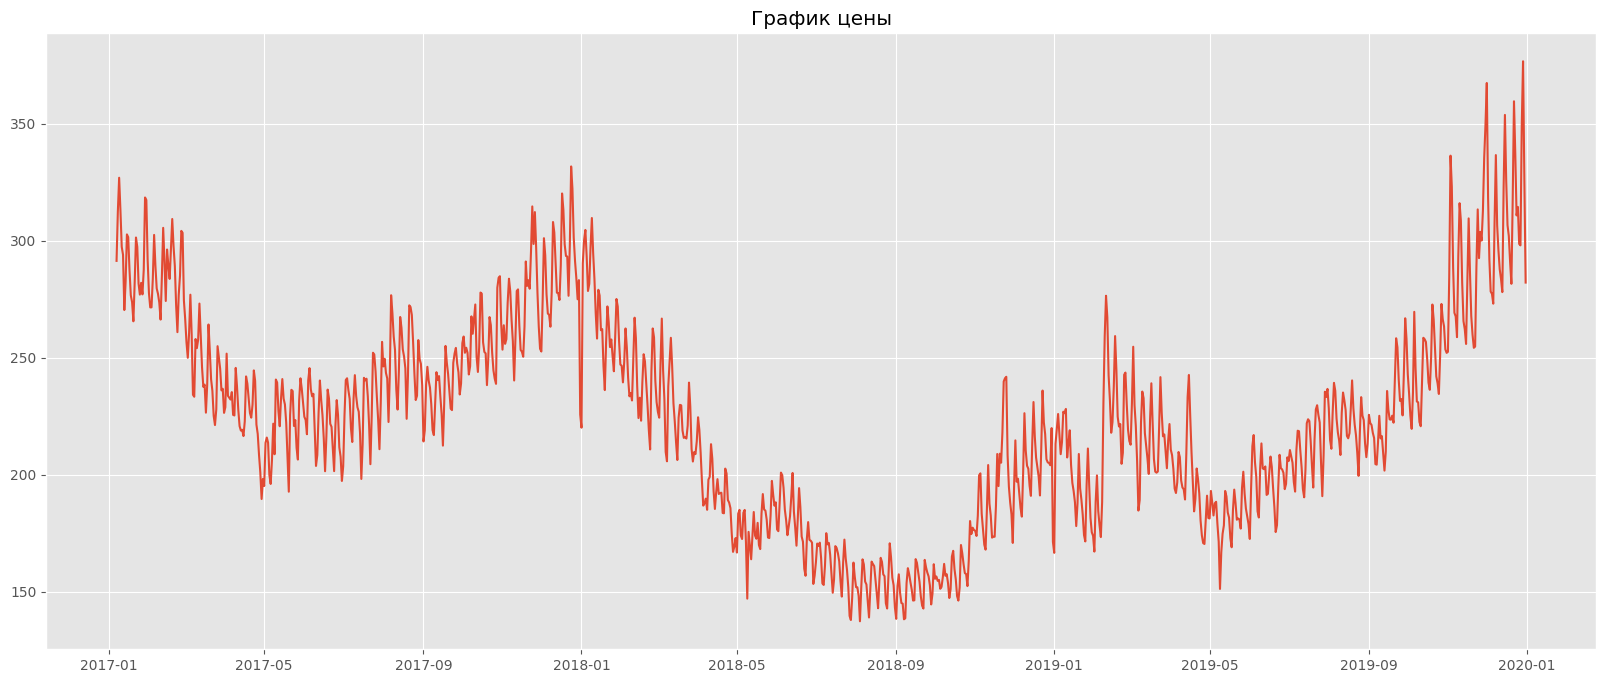

In [21]:
# Отображение временного ряда в графическом виде
plt.figure(figsize=(20, 8))
plt.plot(data.index, data[COL_CLOSE])
plt.title('График цены')
plt.show()

Разделение данных на обучающую, валидационную и тестовую выборки

Разделение данных в пропорции 80/10/10:
- 80% - обучающая выборка
- 10% - валидационная выборка
- 10% - тестовая выборка

In [22]:
# 1. Разделение 80 / 10 / 10
total_len = len(data)
train_end = int(total_len * 0.8)
val_end   = int(total_len * 0.9)

train_df = data.iloc[:train_end]
val_df   = data.iloc[train_end:val_end]
test_df  = data.iloc[val_end:]

Масштабирование данных

Применение MinMaxScaler для нормализации данных:
- Отдельный scaler для признаков (X)
- Отдельный scaler для целевой переменной (y)
Преобразование всех выборок (обучающей, валидационной, тестовой)

In [23]:
# 2. Масштабирование (отдельно признаки и цель)
feature_scaler = MinMaxScaler()
target_scaler  = MinMaxScaler()

X_train = feature_scaler.fit_transform(train_df)
X_val   = feature_scaler.transform(val_df)
X_test  = feature_scaler.transform(test_df)

y_train = target_scaler.fit_transform(train_df[['Close']])
y_val   = target_scaler.transform(val_df[['Close']])
y_test  = target_scaler.transform(test_df[['Close']])

Создание генераторов временных рядов

Генераторы создают последовательности для обучения LSTM-сети:
- seq_len = 60 - длина каждой последовательности (60 временных шагов)
- batch_sz = 20 - размер батча для обучения
- stride=1 - шаг между последовательностями
- sampling_rate=1 - частота выборки точек

In [24]:
# 3. TimeseriesGenerator
seq_len   = 60      # «длина истории» для одного примера
batch_sz  = 20

train_gen = TimeseriesGenerator(X_train, y_train,
                                length=seq_len, stride=1,
                                sampling_rate=1, batch_size=batch_sz)

val_gen   = TimeseriesGenerator(X_val, y_val,
                                length=seq_len, stride=1,
                                sampling_rate=1, batch_size=batch_sz)

test_gen  = TimeseriesGenerator(X_test, y_test,
                                length=seq_len, stride=1,
                                sampling_rate=1, batch_size=1)

Создание и обучение LSTM-модели

Архитектура модели:
1. LSTM-слой с 5 нейронами (принимает входные последовательности)
2. Полносвязный слой с 16 нейронами и активацией ReLU
3. Выходной слой с 1 нейроном (линейная активация)

Модель компилируется с:
- Оптимизатором Adam с learning_rate=1e-5
- Функцией потерь MSE (среднеквадратичная ошибка)

Обучение проводится:
- 20 эпох
- На данных train_gen
- С валидацией на val_gen

In [33]:
model = Sequential([
    LSTM(5, input_shape=(seq_len, X_train.shape[1])),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse')

history = model.fit(train_gen,
                         epochs=20,
                         validation_data=val_gen,
                         verbose=2)

Epoch 1/20
41/41 - 2s - 56ms/step - loss: 0.2177 - val_loss: 0.2045
Epoch 2/20
41/41 - 0s - 6ms/step - loss: 0.2150 - val_loss: 0.2013
Epoch 3/20
41/41 - 0s - 6ms/step - loss: 0.2122 - val_loss: 0.1982
Epoch 4/20
41/41 - 0s - 6ms/step - loss: 0.2095 - val_loss: 0.1952
Epoch 5/20
41/41 - 0s - 6ms/step - loss: 0.2068 - val_loss: 0.1922
Epoch 6/20
41/41 - 0s - 6ms/step - loss: 0.2042 - val_loss: 0.1893
Epoch 7/20
41/41 - 0s - 6ms/step - loss: 0.2017 - val_loss: 0.1865
Epoch 8/20
41/41 - 0s - 6ms/step - loss: 0.1992 - val_loss: 0.1836
Epoch 9/20
41/41 - 0s - 6ms/step - loss: 0.1968 - val_loss: 0.1810
Epoch 10/20
41/41 - 0s - 6ms/step - loss: 0.1944 - val_loss: 0.1786
Epoch 11/20
41/41 - 0s - 6ms/step - loss: 0.1921 - val_loss: 0.1760
Epoch 12/20
41/41 - 0s - 6ms/step - loss: 0.1898 - val_loss: 0.1736
Epoch 13/20
41/41 - 0s - 6ms/step - loss: 0.1876 - val_loss: 0.1712
Epoch 14/20
41/41 - 0s - 6ms/step - loss: 0.1854 - val_loss: 0.1689
Epoch 15/20
41/41 - 0s - 6ms/step - loss: 0.1833 - val_l

Визуализация процесса обучения

График изменения функции потерь:
- Синяя линия - ошибка на обучающей выборке
- Оранжевая линия - ошибка на валидационной выборке

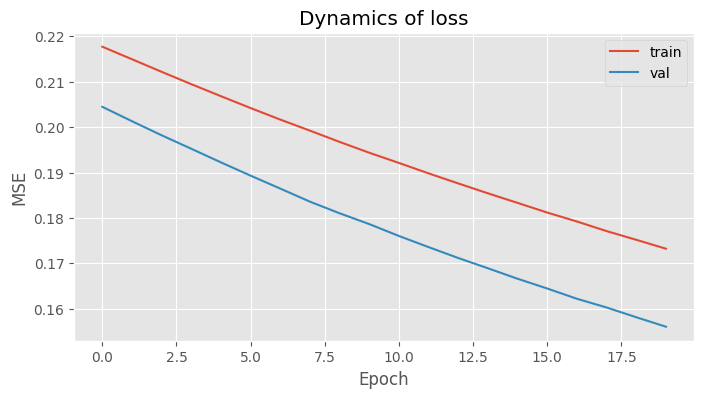

In [34]:
# 6. График ошибки
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Dynamics of loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

Вспомогательные функции для оценки модели

1. get_pred - получает предсказания и истинные значения в исходном масштабе
2. show_predict - отображает график сравнения предсказаний и реальных значений
3. correlate - вычисляет коэффициент корреляции
4. show_corr - отображает графики кросс-корреляции и автокорреляции

In [35]:
# ----- Служебные функции для прогноза и визуализации -----
def get_pred(model, generator, scaler_y):
    """Возвратить предсказание и истину в исходном масштабе."""
    y_pred_scaled = model.predict(generator).flatten().reshape(-1, 1)
    y_true_scaled = np.concatenate([y for _, y in generator]).reshape(-1, 1)
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
    y_true = scaler_y.inverse_transform(y_true_scaled).flatten()
    return y_pred, y_true

def show_predict(y_pred, y_true, start=0, length=300,
                 title='Прогноз LSTM vs Факт'):
    end = start + length
    plt.figure(figsize=(14,4))
    plt.plot(y_true[start:end], label='Факт')
    plt.plot(y_pred[start:end], label='Прогноз')
    plt.title(title)
    plt.xlabel('Относительный индекс времени')
    plt.ylabel('Close')
    plt.legend()
    plt.show()

def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

def show_corr(y_pred, y_true, back_steps_max=30,
              title='Кросс-/автокорреляции'):
    steps = range(0, back_steps_max + 1)
    cross_corr = [correlate(y_true[:-s or None], y_pred[s:]) for s in steps]
    auto_corr  = [correlate(y_true[:-s or None], y_true[s:]) for s in steps]
    plt.figure(figsize=(10,5))
    plt.plot(steps, cross_corr, marker='o', label='Прогноз vs Факт')
    plt.plot(steps, auto_corr,  marker='o', label='Факт vs Факт')
    plt.xticks(steps)
    plt.xlabel('Смещение (шагов)')
    plt.ylabel('Коэффициент корреляции')
    plt.title(title)
    plt.legend()
    plt.show()

Оценка модели на тестовых данных

1. Подготовка последовательностей для тестовых данных
2. Получение предсказаний модели
3. Обратное масштабирование данных
4. Визуализация результатов:
   - График сравнения предсказаний и реальных значений (первые 500 точек)
   - Графики корреляции и автокорреляции

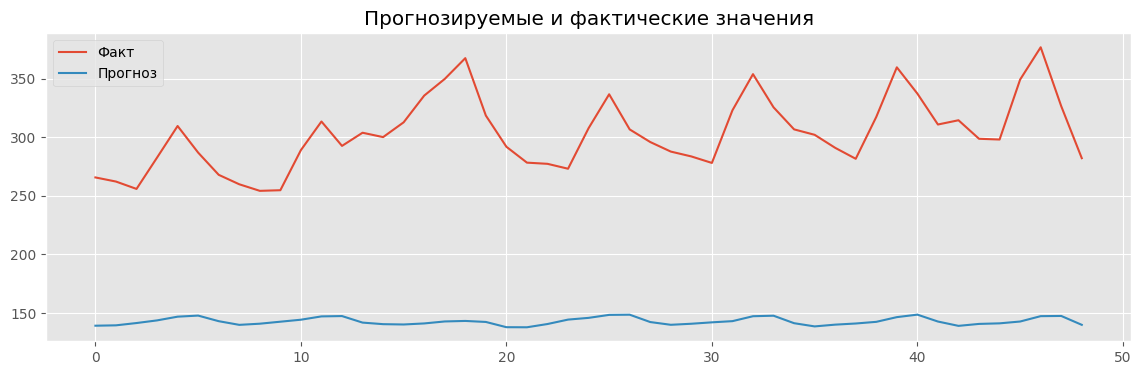

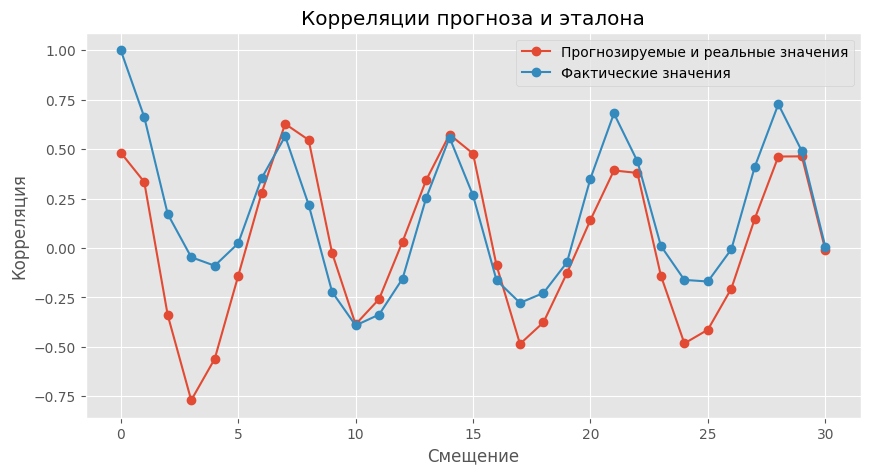

In [36]:
# Получаем входы и цели вручную из X_test и y_test
X_test_seq = np.array([X_test[i - seq_len:i] for i in range(seq_len, len(X_test))])
y_test_seq = y_test[seq_len:]

# Прогноз (в масштабе)
y_pred_scaled = model.predict(X_test_seq, batch_size=32, verbose=0)

# Обратное масштабирование
y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()
y_true = target_scaler.inverse_transform(y_test_seq).flatten()

# Отобразим только первые 500 точек
plot_len = min(500, len(y_pred))

plt.figure(figsize=(14, 4))
plt.plot(y_true[:plot_len], label='Факт')
plt.plot(y_pred[:plot_len], label='Прогноз')
plt.title('Прогнозируемые и фактические значения')
plt.legend()
plt.show()

# Корреляции (только на 500 точках)
def safe_correlate(a, b):
    return np.corrcoef(a, b)[0, 1] if len(a) > 1 else 0

steps = range(0, 30 + 1)
cross_corr = [safe_correlate(y_true[:plot_len - s], y_pred[s:plot_len]) for s in steps]
auto_corr =  [safe_correlate(y_true[:plot_len - s], y_true[s:plot_len]) for s in steps]

plt.figure(figsize=(10, 5))
plt.plot(steps, cross_corr, marker='o', label='Прогнозируемые и реальные значения')
plt.plot(steps, auto_corr, marker='o', label='Фактические значения')
plt.title('Корреляции прогноза и эталона')
plt.xlabel('Смещение')
plt.ylabel('Корреляция')
plt.legend()
plt.show()